In [1]:
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
# import electrode
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped, utils)
from scipy.signal import argrelextrema



np.set_printoptions(precision=2) # have numpy print fewer digits

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def line_trap(bottom, top, left, right, center_height, rf_height):
    ch = center_height
    rh = rf_height
    b = bottom
    t = top
    l = left
    r = right
    electrodes = [
        ("ct", [[(-l, t), (-l, rh + ch/2), (r, rh + ch/2), (r, t)]]),
        ("rt", [[(-l, rh + ch/2), (-l, ch/2), (r, ch/2), (r, rh + ch/2)]]),
        ("cc", [[(-l, ch/2), (-l, -ch/2), (r, -ch/2), (r, ch/2)]]),
        ("rb", [[(-l, - ch/2), (-l, -rh - ch/2), (r, -rh - ch/2), (r, -ch/2)]]),
        ("cb", [[(-l, -rh - ch/2), (-l, -b), (r, -b), (r, -rh - ch/2)]]),
        ]
    
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p))
                for n, p in electrodes])

    s["rt"].rf = 1.
    s["rb"].rf = 1.
    return s

In [4]:
# Segmented RF Trap

In [5]:
def segment_rf_trap(bottom, top, left, right, center_height, rf_height1, rf_height2):
    ch = center_height
    rh1 = rf_height1
    rh2 = rf_height2
    b = bottom
    t = top
    l = left
    r = right
    electrodes = [
        ("ct", [[(-l, t), (-l, rh1 + rh2 + ch/2), (r, rh1 + rh2 + ch/2), (r, t)]]),
        ("r1", [[(-l, rh1 + ch/2), (-l, ch/2), (r, ch/2), (r, rh1 + ch/2)],
                [(-l, -ch/2), (-l, -rh1 - ch/2), (r, -rh1 - ch/2), (r, -ch/2)]]),
        ("cc", [[(-l, ch/2), (-l, -ch/2), (r, -ch/2), (r, ch/2)]]),
        ("r2", [[(-l, rh1 + rh2 + ch/2), (-l, rh1 + ch/2), (r, rh1 + ch/2), (r, rh1 + rh2 + ch/2)],
                [(-l, -rh1 - ch/2), (-l, -rh1 - rh2 - ch/2), (r, -rh1 - rh2 - ch/2), (r, -rh1 - ch/2)]]),
        ("cb", [[(-l, -rh1 - rh2 - ch/2), (-l, -b), (r, -b), (r, -rh1 - rh2 - ch/2)]]),
        ]
    
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p))
                for n, p in electrodes])
   
    s["r1"].rf = 1.
    s["r2"].rf = 1.
    return s

[Text(0.5, 1.0, 'Electrode Diagram of Segmented Linear Junction')]

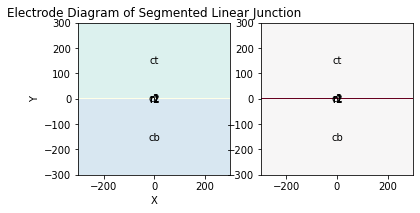

In [6]:
rh = 0.581
ch = 0.407

r = 300

lin_junc = line_trap(r, r, r, r, ch, rh)

rh1 = 0.99
rh2 = 1
# rh1 = 1.99
# rh2 = 0

ch = 0.83

r = 300
# r = 8

base_seg_lin_junc = segment_rf_trap(r, r, r, r, ch, rh1, rh2)
am_seg_lin_junc = segment_rf_trap(r, r, r, r, ch, rh1, rh2)
am2_seg_lin_junc = segment_rf_trap(r, r, r, r, ch, rh1, rh2)
fm_seg_lin_junc = segment_rf_trap(r, r, r, r, ch, rh1, rh2)
# (bottom, top, left, right, center_height, rf_height1, rf_height2)

fig, ax = plt.subplots(1, 2)
base_seg_lin_junc.plot(ax[0])
base_seg_lin_junc.plot_voltages(ax[1], u=base_seg_lin_junc.rfs)

for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-r, r)
    axi.set_ylim(-r, r)

plt.setp(ax[0], xlabel = "X")
plt.setp(ax[0], ylabel = "Y")
plt.setp(ax[0], title = "Electrode Diagram of Segmented Linear Junction")


In [7]:
l = 50e-6 # µm length scale

u1 = 100. # V rf peak voltage
u2 = 100.

m = 40*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge

o1 = 80*np.pi*1e6 # rf frequency in rad/s
o2 = 80*np.pi*1e6 # rf frequency in rad/s

rf_scale1 = np.sqrt(q/m)/(2*l*o1) # scaling factor for sim
rf_scale2 = np.sqrt(q/m)/(2*l*o2) # scaling factor for sim

base_seg_lin_junc["r1"].rf = u1*rf_scale1
base_seg_lin_junc["r2"].rf = u2*rf_scale2

lin_u1 = 40

lin_junc["rt"].rf = lin_u1 * rf_scale1
lin_junc["rb"].rf = lin_u1 * rf_scale1



# Amplitude Modulation

am_u1 = 100. # V rf peak voltage
am_u2 = 50.

am_seg_lin_junc["r1"].rf = am_u1*rf_scale1
am_seg_lin_junc["r2"].rf = am_u2*rf_scale2

# AM2

am2_u1 = 100. # V rf peak voltage
am2_u2 = 150.

am2_seg_lin_junc["r1"].rf = am2_u1*rf_scale1
am2_seg_lin_junc["r2"].rf = am2_u2*rf_scale2

fm_o1 = 80*np.pi*1e6 # rf frequency in rad/s
fm_o2 = 40*np.pi*1e6 # rf frequency in rad/s

# Frequency Modulation

fm_rf_scale1 = np.sqrt(q/m)/(2*l*fm_o1) # scaling factor for sim
fm_rf_scale2 = np.sqrt(q/m)/(2*l*fm_o2) # scaling factor for sim

fm_seg_lin_junc["r1"].rf = u1*fm_rf_scale1
fm_seg_lin_junc["r2"].rf = u2*fm_rf_scale2



In [8]:
def pot_contour_map(junction, spec_title, n = 200, ncontours = 1000, x = 0, start_y = -2, end_y = 2, start_z = 0, end_z = 2):
    xyz = np.mgrid[x:x+1, start_y:end_y:1j*n, start_z:end_z:1j*n] 

    fig, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
    pot = shaped(junction.potential)(xyz, derivative = 0)
    y, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))

    levs = np.linspace(-18, 10, ncontours)

    surf1 = ax.contourf(y, z, np.log2(p), levels=levs, cmap=plt.cm.hot) # plot the voltage contours
    cbar = fig.colorbar(surf1, shrink = 0.5, aspect = 20)
    cbar.ax.set_ylabel("Log_2 Potentials (eV)")

    plt.setp(ax, xlabel = "Y")
    plt.setp(ax, ylabel = "Z")
    plt.setp(ax, title = spec_title)

    # electron volts

    print (np.amin(p))
    point = np.unravel_index( np.argmin(p), np.shape(p))
    print (y[point[0]][point[1]])
    print (z[point[0]][point[1]])

0.0004613132405804868
0.010050251256281229
0.9949748743718593
0.0007067755459286769
-0.01005025125628145
0.8743718592964824
0.00031152450626640763
-0.01005025125628145
1.206030150753769


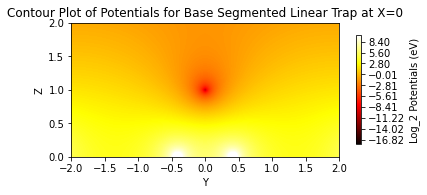

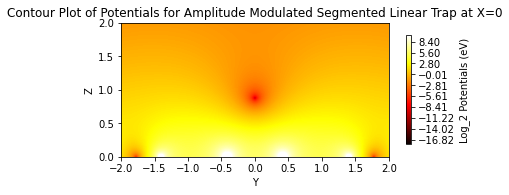

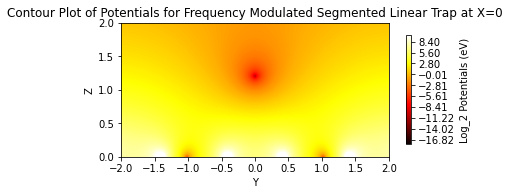

In [9]:
pot_contour_map(base_seg_lin_junc, "Contour Plot of Potentials for Base Segmented Linear Trap at X=0")
pot_contour_map(am_seg_lin_junc, "Contour Plot of Potentials for Amplitude Modulated Segmented Linear Trap at X=0")
pot_contour_map(fm_seg_lin_junc, "Contour Plot of Potentials for Frequency Modulated Segmented Linear Trap at X=0")

In [10]:
def pull_conf_values(junction, n = 1000, start_z = 0.8, end_z = 1.5, x_search = 0, y_search = 0):
    # extracts potential confinement values
    x = x_search
    y = y_search

    xyz = np.mgrid[x:x+1, y:y+1, start_z:end_z:1j*n]

    pre_pot2 = shaped(junction.potential)(xyz, derivative = 2)
    pre_pot = np.zeros((1, 1, n))
        
    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pre_pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][0][0]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][1][1]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][2][2]
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    pre_z_conf_values = np.reshape(pre_pot, (n))

    pre_z_conf_values /= (l ** 2) # eV / m^2
    pre_z_conf_values *= 1e3 # meV / m^2
    pre_z_conf_values /= ((1e6) ** 2) # meV / micron^2


    z_values = np.reshape(xyz[2], (n))

    return [z_values, pre_z_conf_values]

In [11]:
def pull_potential_values(junction, n = 1000, start_z = 0.8, end_z = 1.5, x_search = 0, y_search = 0):
    # pull potential values
    x = x_search
    y = y_search

    xyz = np.mgrid[x:x+1, y:y+1, start_z:end_z:1j*n]
        

    pot2 = shaped(junction.potential)(xyz, derivative = 0)
    pot = np.zeros((1, 1, n))

    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                curr_grad = pot2[i_counter][j_counter][k_counter]
                pot[i_counter][j_counter][k_counter] += curr_grad
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    z_pot_values = np.reshape(pot, (n))

    z_values = np.reshape(xyz[2], (n))

    return [z_values, z_pot_values]

In [24]:
def pull_y_potential_values(junction, n = 1000, start_y = -3, end_y = 3, x_search = 0, z_search = 1):
    # pull potential values
    x = x_search
    z = z_search


    xyz = np.mgrid[x:x+1, start_y:end_y:1j*n, z:z+1]
        

    pot2 = shaped(junction.potential)(xyz, derivative = 0)
    pot = np.zeros((1, n, 1))

    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                curr_grad = pot2[i_counter][j_counter][k_counter]
                pot[i_counter][j_counter][k_counter] += curr_grad
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    y_pot_values = np.reshape(pot, (n))

    y_values = np.reshape(xyz[1], (n))

    return [y_values, y_pot_values]

In [51]:
def pull_z_grad_values(junction, n = 1000, start_z = 0.8, end_z = 3, x_search = 0, y_search = 0):
    # pull z gradient
    x = x_search
    y = y_search

    xyz = np.mgrid[x:x+1, y:y+1, start_z:end_z:1j*n]

    pot2 = shaped(junction.potential)(xyz, derivative = 1)
    pot = np.zeros((1, 1, n))

    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                curr_grad = pot2[i_counter][j_counter][k_counter][2]
                pot[i_counter][j_counter][k_counter] += curr_grad
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    z_grad_values = np.reshape(pot, (n))

    z_values = np.reshape(xyz[2], (n))

    z_grad_values /= l # eV / m
    z_grad_values /= 1e6 # eV / micron

    return [z_values, z_grad_values]

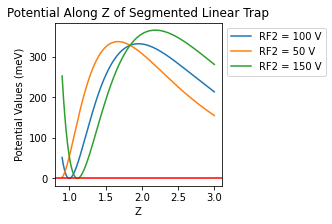

In [55]:
# Potential Along Z

# line_z_values, line_z_pot = pull_potential_values(lin_junc, n = 1000, start_z = 0.39, end_z = 0.6)
base_z_values, base_z_pot = pull_potential_values(base_seg_lin_junc, n = 1000, start_z = 0.9, end_z = 3)
am_z_values, am_z_pot = pull_potential_values(am_seg_lin_junc, n = 1000, start_z = 0.9, end_z = 3)
am2_z_values, am2_z_pot = pull_potential_values(am2_seg_lin_junc, n = 1000, start_z = 0.9, end_z = 3)
# fm_z_values, fm_z_pot = pull_potential_values(fm_seg_lin_junc)


plt.figure(figsize = (3,3))
# plt.plot(line_z_values, line_z_pot * 1e3)
# plt.plot(base_z_values, base_z_pot * 1e3, label = "Uniform")
plt.plot(base_z_values, base_z_pot * 1e3, label = "RF2 = 100 V")
# plt.plot(am_z_values, am_z_pot * 1e3, label = "Amplitude Modulated")
plt.plot(am_z_values, am_z_pot * 1e3, label = "RF2 = 50 V")
plt.plot(am2_z_values, am2_z_pot * 1e3, label = "RF2 = 150 V")
# plt.plot(fm_z_values, fm_z_pot * 1e3, label = "Frequency Modulated")
plt.xlabel("Z")
plt.ylabel("Potential Values (meV)")
plt.title("Potential Along Z of Segmented Linear Trap")
plt.legend(loc = 'best', bbox_to_anchor = (1,1))
plt.show()

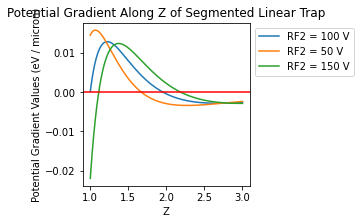

In [58]:
# Gradient Along Z

grad_start_z = 3
grad_end_z = 1
n_grad = 1000

base_z_values, base_z_grad = pull_z_grad_values(base_seg_lin_junc, n = n_grad, start_z = grad_start_z, end_z = grad_end_z)
am_z_values, am_z_grad = pull_z_grad_values(am_seg_lin_junc, n = n_grad, start_z = grad_start_z, end_z = grad_end_z)
am2_z_values, am2_z_grad = pull_z_grad_values(am2_seg_lin_junc, n = n_grad, start_z = grad_start_z, end_z = grad_end_z)


plt.figure(figsize = (3,3))
plt.plot(base_z_values, base_z_grad, label = "RF2 = 100 V")
plt.plot(am_z_values, am_z_grad, label = "RF2 = 50 V")
plt.plot(am2_z_values, am2_z_grad, label = "RF2 = 150 V")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel("Z")
plt.ylabel("Potential Gradient Values (eV / micron)")
plt.title("Potential Gradient Along Z of Segmented Linear Trap")
plt.legend(loc = 'best', bbox_to_anchor = (1,1))
plt.show()

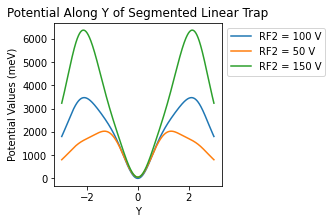

In [25]:
# Potential Along Y

# line_y_values, line_y_pot = pull_potential_values(lin_junc, n = 1000, start_z = 0.39, end_z = 0.6)
base_y_values, base_y_pot = pull_y_potential_values(base_seg_lin_junc)
am_y_values, am_y_pot = pull_y_potential_values(am_seg_lin_junc)
am2_y_values, am2_y_pot = pull_y_potential_values(am2_seg_lin_junc)
# fm_y_values, fm_y_pot = pull_potential_values(fm_seg_lin_junc)


plt.figure(figsize = (3,3))
# plt.plot(line_y_values, line_y_pot * 1e3)
# plt.plot(base_y_values, base_y_pot * 1e3, label = "Uniform")
plt.plot(base_y_values, base_y_pot * 1e3, label = "RF2 = 100 V")
# plt.plot(am_y_values, am_y_pot * 1e3, label = "Amplitude Modulated")
plt.plot(am_y_values, am_y_pot * 1e3, label = "RF2 = 50 V")
plt.plot(am2_y_values, am2_y_pot * 1e3, label = "RF2 = 150 V")
# plt.plot(fm_y_values, fm_y_pot * 1e3, label = "Frequency Modulated")
plt.xlabel("Y")
plt.ylabel("Potential Values (meV)")
plt.title("Potential Along Y of Segmented Linear Trap")
plt.legend(loc = 'best', bbox_to_anchor = (1,1))
plt.show()

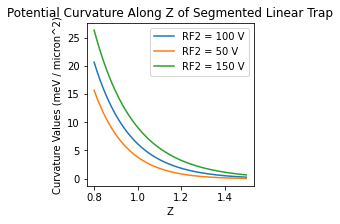

In [24]:
# Curvature Along Z

base_z_values, base_z_conf = pull_conf_values(base_seg_lin_junc)
am_z_values, am_z_conf = pull_conf_values(am_seg_lin_junc)
am2_z_values, am2_z_conf = pull_conf_values(am2_seg_lin_junc)
# fm_z_values, fm_z_conf = pull_conf_values(fm_seg_lin_junc)
# line_z_values, line_z_conf = pull_conf_values(lin_junc, n = 1000, start_z = 0.39, end_z = 0.41)

plt.figure(figsize = (3,3))
# plt.plot(base_z_values, base_z_conf, label = "Uniform")
# plt.plot(line_z_values, line_z_conf, label = "Linear")
plt.plot(base_z_values, base_z_conf, label = "RF2 = 100 V")
# plt.plot(am_z_values, am_z_conf, label = "Amplitude Modulated")
plt.plot(am_z_values, am_z_conf, label = "RF2 = 50 V")
plt.plot(am2_z_values, am2_z_conf, label = "RF2 = 150 V")
# plt.plot(fm_z_values, fm_z_conf, label = "Frequency Modulated")
plt.xlabel("Z")
plt.ylabel("Curvature Values (meV / micron^2)")
plt.title("Potential Curvature Along Z of Segmented Linear Trap")
plt.legend(loc = 'best', bbox_to_anchor = (1,1))
plt.show()

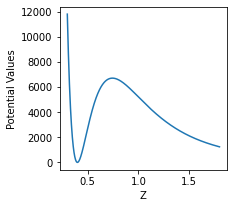

In [142]:
rh1 = 0.581
rh2 = 3.
ch1 = 0.407

r = 300
var_seg_lin_junc = segment_rf_trap(r, r, r, r, ch1, rh1, rh2)


l = 50e-6 # µm length scale
u1 = 20. # V rf peak voltage
m = 40*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
o = 80*np.pi*1e6 # rf frequency in rad/s
rf_scale = np.sqrt(q/m)/(2*l*o) # scaling factor for sim

n_voltages = 101

trap_heights = np.zeros((n_voltages))
trap_confinements = np.zeros((n_voltages))
rf2_voltages = np.zeros((n_voltages))
rf1_voltages = np.zeros((n_voltages))

for i in range(n_voltages):
    min_u2 = 0
    max_u2 = 200
    delta_u2 = (max_u2 - min_u2) / n_voltages



    u2 = min_u2 + (i * delta_u2)

    u1 = 20

    if (u1 > u2):
        cprop = u2 / u1 
        u1 = 200 
        u2 = cprop * 200
    else:
        cprop = u1 / u2 
        u2 = 200 
        u1 = cprop * 200

    var_seg_lin_junc["r1"].rf = u1*rf_scale
    var_seg_lin_junc["r2"].rf = u2*rf_scale

    var_z_values, var_z_pot = pull_potential_values(var_seg_lin_junc, n = 1000, start_z = 0.3, end_z = 1.8)
    var_z_values, var_z_conf = pull_conf_values(var_seg_lin_junc, n = 1000, start_z = 0.3, end_z = 1.8)

    point = np.unravel_index( np.argmin(var_z_pot), np.shape(var_z_pot))

    trap_heights[i] = var_z_values[point]
    trap_confinements[i] = var_z_conf[point]
    rf2_voltages[i] = u2
    rf1_voltages[i] = u1

    if (u2 == 0):
        plt.figure(figsize = (3,3))
        plt.plot(var_z_values, var_z_pot * 1e3)
        plt.xlabel("Z")
        plt.ylabel("Potential Values")
        plt.show()
        



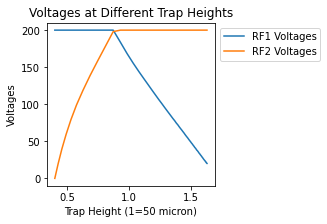

In [143]:
plt.figure(figsize = (3,3))
plt.plot(trap_heights, rf1_voltages, label = "RF1 Voltages")
plt.plot(trap_heights, rf2_voltages, label = "RF2 Voltages")
plt.xlabel("Trap Height (1=50 micron)")
plt.ylabel("Voltages")
plt.title("Voltages at Different Trap Heights")
plt.legend(loc = 'best', bbox_to_anchor = (1,1))
plt.show()

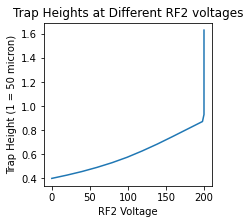

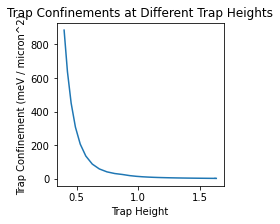

3.2281767448312437


In [144]:
plt.figure(figsize = (3,3))
plt.plot(rf2_voltages, trap_heights)
plt.xlabel("RF2 Voltage")
plt.ylabel("Trap Height (1 = 50 micron)")
plt.title("Trap Heights at Different RF2 voltages")
plt.show()

plt.figure(figsize = (3,3))
plt.plot(trap_heights, trap_confinements)
plt.xlabel("Trap Height")
plt.ylabel("Trap Confinement (meV / micron^2)")
plt.title("Trap Confinements at Different Trap Heights")
plt.show()

print(np.amin(trap_confinements))



